## Семинар 2 "Распознавание рукописных цифр"

ФИО: Горелова Анна Антоновна

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [59]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/home/anna/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

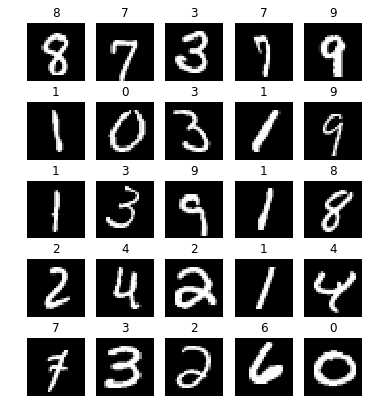

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [6]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.327/0.321	Accuracy: 0.914/0.916

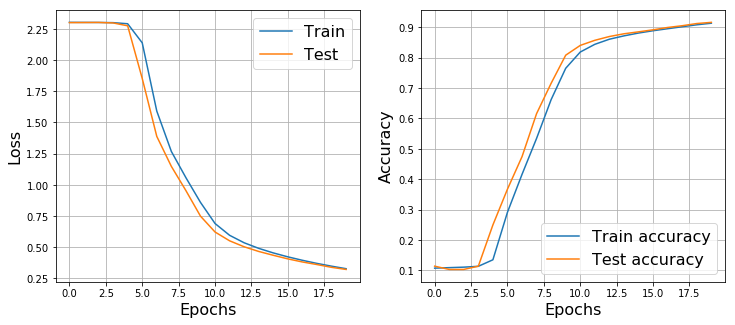

In [7]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [8]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [57]:
# class ReLU:
#     def __init__(self):
#         pass

#     def forward(self, X):
#         '''
#         Passes objects through this layer.
#         X is np.array of size (N, d)
#         '''
#         self.X = X
#         return np.maximum(X, 0)

#     def backward(self, dLdy):
#         '''
#         1. Compute dLdx.
#         2. Return dLdx
#         '''
#         dydX = (self.X >= 0).astype(float)
#         return dLdy*dydX

#     def step(self, learning_rate):
#         pass

In [9]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.034/0.083	Accuracy: 0.991/0.975

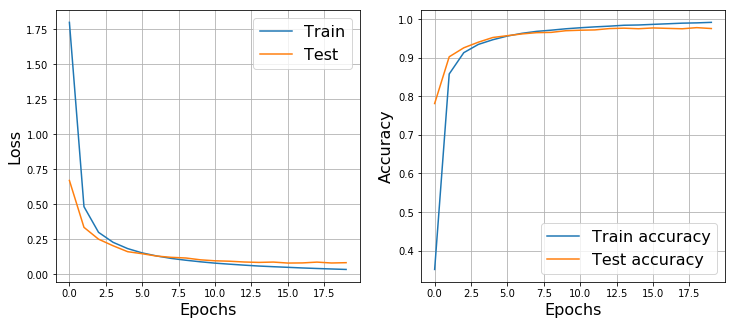

In [10]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.047/0.078	Accuracy: 0.987/0.975

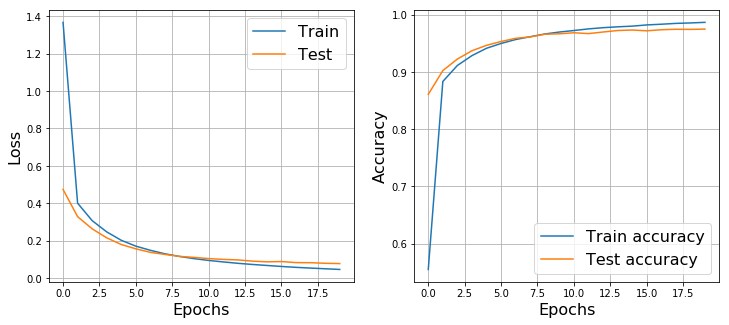

In [11]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

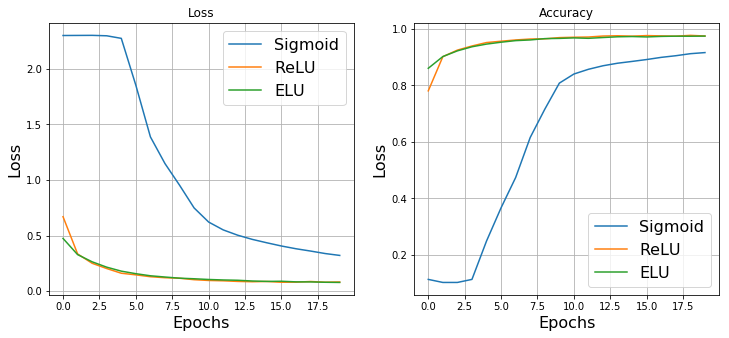

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

In [19]:
class Tanh:
        
    def __init__(self):
        pass
    
    def forward(self, X):
        self.X = X
        return (np.exp(2*X) - 1)/(np.exp(2*X) + 1)
    
    def backward(self, dLdy):
        X = self.X
        return (1 - ((np.exp(2*X) - 1)/(np.exp(2*X) + 1))**2) * dLdy
    
    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.031/0.077	Accuracy: 0.994/0.976

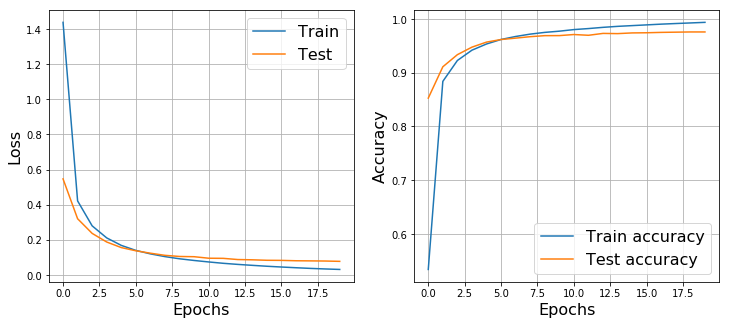

In [20]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

### Часть 3: Анализ ошибок

In [17]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

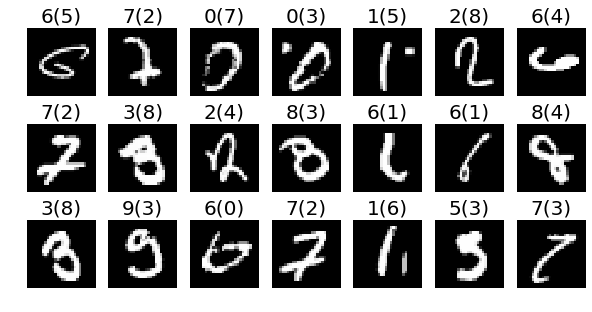

In [18]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [77]:
def aug_train(transform):
    train_dataset = MNIST('.', train=True, download=True, transform=transform)
    test_dataset = MNIST('.', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    X, y = next(iter(train_loader))
    X = X.numpy()
    y = y.numpy()
    network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
    loss = NLLLoss()
    tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

In [78]:
def diff_transform(aug_type1):
    transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
    train_dataset = MNIST('.', train=True, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    X, y = next(iter(train_loader))
    X = X.numpy()
    y = y.numpy()
    fig = plt.figure(figsize=(6, 7))
    fig.suptitle('Original images', fontsize=16)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title(y[i])
        plt.axis('off')
        
    
    train_dataset = MNIST('.', train=True, download=True, transform=aug_type1)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    X, y = next(iter(train_loader))
    X = X.numpy()
    y = y.numpy()
    fig = plt.figure(figsize=(6, 7))
    fig.suptitle('Transformed images', fontsize=16)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title(y[i])
        plt.axis('off')

#### Вращение

In [79]:
from torchvision.transforms import RandomRotation

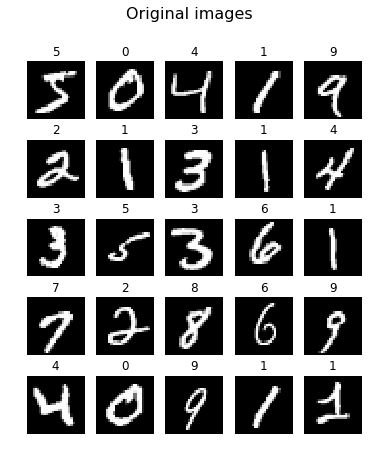

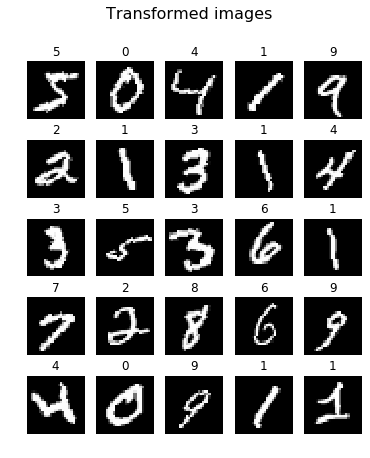

In [82]:
transform = transforms.Compose([
                    transforms.RandomRotation(degrees=(-15,15)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                    ])
diff_transform(transform)

Epoch 19... (Train/Test) NLL: 0.094/0.120	Accuracy: 0.970/0.963

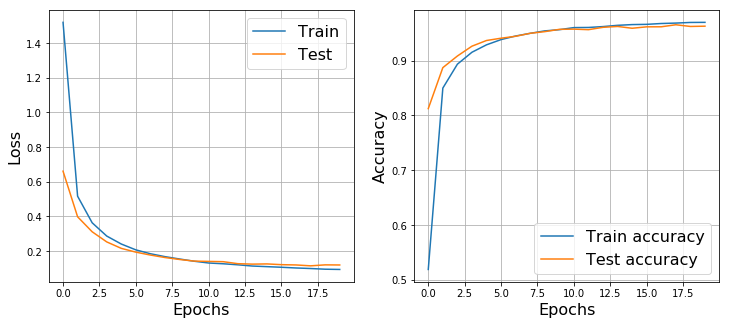

In [83]:
aug_train(transform)

Качество на тесте не улучшилось

#### Случайные сдвиги

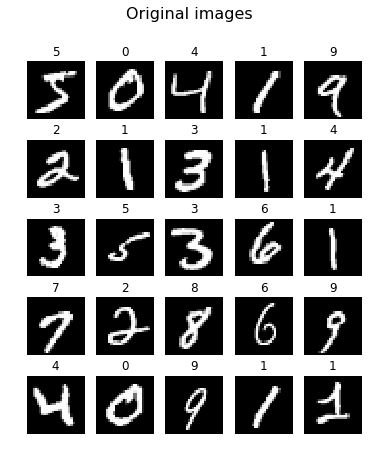

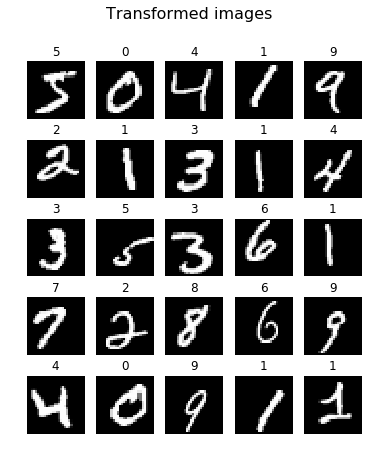

In [84]:
transform = transforms.Compose([
                    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                    ])
diff_transform(transform)

Epoch 19... (Train/Test) NLL: 0.093/0.108	Accuracy: 0.971/0.966

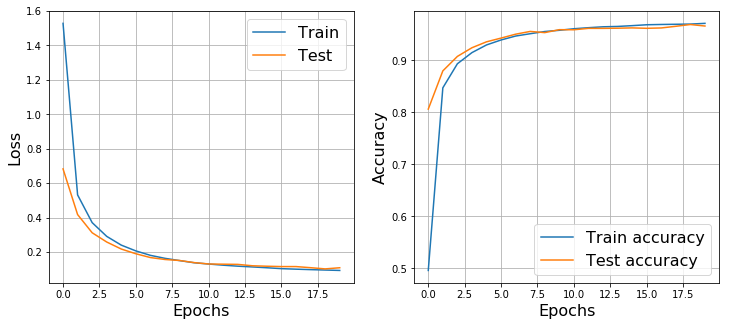

In [85]:
aug_train(transform)

#### Шум

In [88]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    

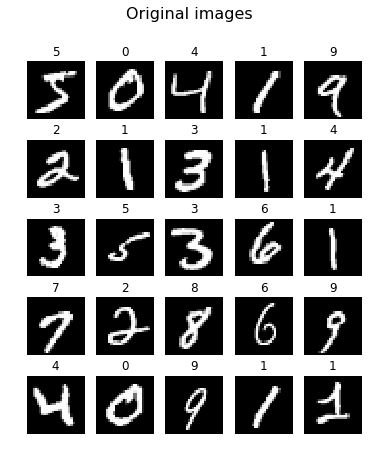

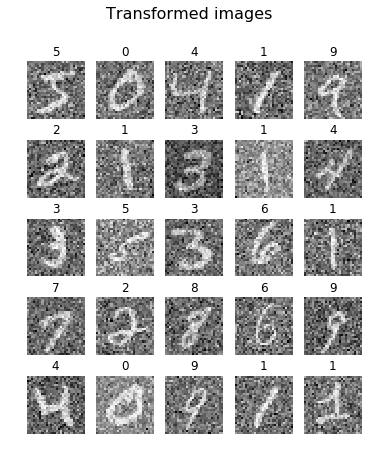

In [89]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                    AddGaussianNoise(0., 1.)
                    ])
diff_transform(transform)

Epoch 19... (Train/Test) NLL: 0.094/0.113	Accuracy: 0.970/0.963

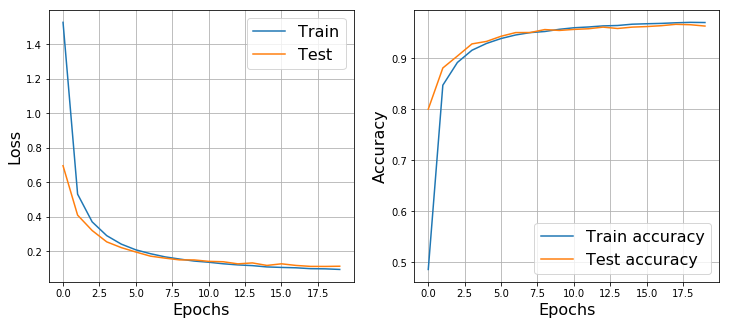

In [90]:
aug_train(transform)

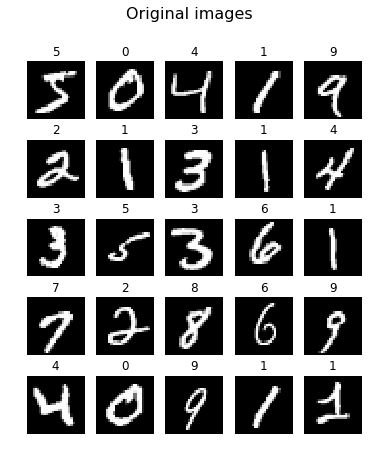

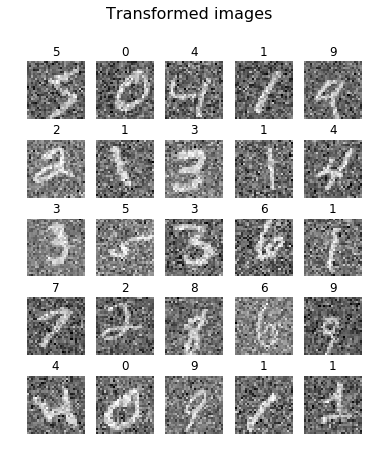

In [91]:
transform = transforms.Compose([
                       transforms.RandomRotation(degrees=(-15,15)),
                       transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                        AddGaussianNoise(0., 1.)
                    ])
diff_transform(transform)

Epoch 19... (Train/Test) NLL: 0.096/0.110	Accuracy: 0.970/0.967

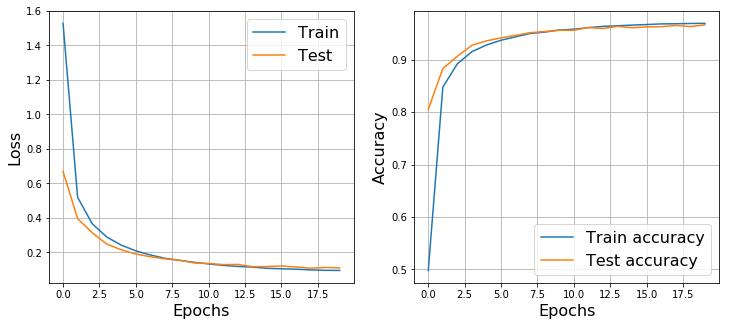

In [92]:
aug_train(transform)

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Из рассмотренных нелинейностей хуже всего показала себя сигмоида, ELU и ReLU дали одинаковые результаты, гиперболический тангенс - наиболее хороший результат. 

Из преобразований лучше всего себя показал сдвиг, но в целом аугментация не дала прироста в качестве